In [1]:
!pip install rasterio
!pip install fiona
!pip install shapely
!pip install geopandas
!pip install pycrs

     ---------------------------------------- 0.0/22.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/22.0 MB ? eta -:--:--
     ---------------------------------------- 0.1/22.0 MB 1.8 MB/s eta 0:00:13
      --------------------------------------- 0.5/22.0 MB 3.6 MB/s eta 0:00:06
     -- ------------------------------------- 1.2/22.0 MB 7.8 MB/s eta 0:00:03
     --- ------------------------------------ 2.0/22.0 MB 9.8 MB/s eta 0:00:03
     ---- ----------------------------------- 2.5/22.0 MB 10.6 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 11.0 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 9.5 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 9.5 MB/s eta 0:00:02
     ----- ---------------------------------- 3.1/22.0 MB 7.4 MB/s eta 0:00:03
     ----- ---------------------------------- 3.1/22.0 MB 7.4 MB/s eta 0:00:03
     ----- ---------------------------------- 3.1/22.0 MB 7.4 MB

In [2]:
from matplotlib import pyplot as plt
from matplotlib import colors, cm
from matplotlib import ticker
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import re #used for making multiple string splits
import json
import os

from matplotlib.colors import ListedColormap
import numpy as np

In [3]:
#load input file
# fp = r'cgls_landcover_2015_classification.tiff'
fp = "dataPreprocessing/precipitationData/my_test_data.tif"
data = rasterio.open(fp)



In [4]:
def show_land_cover(img):
    #labels for plotting
    labels = {0: {'color': '#282828', 'flag': 'unknown'},
              20: {'color': '#FFBB22', 'flag': 'shrubs'},
              30: {'color': '#FFFF4C', 'flag': 'herbaceous_vegetation'},
              40: {'color': '#F096FF', 'flag': 'cultivated_and_managed_vegetation_or_agriculture'},
              50: {'color': '#FA0000', 'flag': 'urban_or_built_up'},
              60: {'color': '#B4B4B4', 'flag': 'bare_or_sparse_vegetation'},
              70: {'color': '#F0F0F0', 'flag': 'snow_and_ice'},
              80: {'color': '#0032C8', 'flag': 'permanent_water_bodies'},
              90: {'color': '#0096A0', 'flag': 'herbaceous_wetland'},
              100: {'color': '#FAE6A0', 'flag': 'moss_and_lichen'},
              111: {'color': '#58481F', 'flag': 'closed_forest_evergreen_needle_leaf'},
              112: {'color': '#009900', 'flag': 'closed_forest_evergreen_broad_leaf'},
              113: {'color': '#70663E', 'flag': 'closed_forest_deciduous_needle_leaf'},
              114: {'color': '#00CC00', 'flag': 'closed_forest_deciduous_broad_leaf'},
              115: {'color': '#4E751F', 'flag': 'closed_forest_mixed'},
              116: {'color': '#007800', 'flag': 'closed_forest_not_matching_any_of_the_other_definitions'},
              121: {'color': '#666000', 'flag': 'open_forest_evergreen_needle_leaf'},
              122: {'color': '#8DB400', 'flag': 'open_forest_evergreen_broad_leaf'},
              123: {'color': '#8D7400', 'flag': 'open_forest_deciduous_needle_leaf'},
              124: {'color': '#A0DC00', 'flag': 'open_forest_deciduous_broad_leaf'},
              125: {'color': '#929900', 'flag': 'open_forest_mixed'},
              126: {'color': '#648C00', 'flag': 'open_forest_not_matching_any_of_the_other_definitions'},
              200: {'color': '#000080', 'flag': 'oceans_seas'}}
    #colors1 = [label['color'] for label in labels.values()]
    cmap = ListedColormap([label['color'] for label in labels.values()])
    norm = colors.BoundaryNorm(list(labels.keys())+[201], cmap.N+1, extend='max')
    ticks = list(np.mean((list(list(labels.keys())+[201])[i+1], val)) for i, val in enumerate(list(labels.keys())))
    cblabels=[label['flag'] for label in labels.values()]
    
    #file setup
    img_name, _ = img.split("_")
    img_name = img_name + ".tiff"
    print(img_name)
    
    data = None
    with rasterio.open("landcover/"+img_name) as src:
        data = src.read()
        src.close() # close the rasterio dataset
    
    data_array = np.array(data)
    print(np.amin(data_array), np.amax(data_array))
#     print(np.around(data_array, 1))
    data_array = data_array[0,:,:]
    plt.imshow(data_array)
    plt.show()
        
#     src = rasterio.open("landcover/"+img_name)
#     data = src.read()
    
    fig, ax = plt.subplots()

    cb = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=200.5), cmap=cmap), ax=ax)
    tick_locator = ticker.FixedLocator(locs=[(i*(200/23)+5) for i in range(len(ticks))])
    cb.locator = tick_locator
    cb.update_ticks()
    cb.set_ticklabels(cblabels[::-1])

    show(data, ax=ax, cmap=cmap, norm=norm) #transform=src.transform
    
    src.close()

In [5]:
#inspiration from https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
def generate_land_cover_image(satellite_image_name, input_file, view=0.01):
    out_name, coordinates = satellite_image_name.split("_")
    out_name = out_name + ".tiff"
    lat, lon = re.split(", |.png|,", coordinates)[:2]
    lat = float(lat)
    lon = float(lon)
    
    #finding the bounding box of the center coordinate
    up_rightX, up_rightY = round(lat-view,4), round(lon+view,4)
    down_leftX, down_leftY = round(lat+view,4), round(lon-view,4)
    bbox = box(up_rightX,up_rightY,down_leftX,down_leftY)
    print("bbox", bbox)
    
    #Insert the BB to a GeoDataFrame and reproject it into the coordinate system of the input image
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    geo = geo.to_crs(crs=data.crs.data)
    
    #Now we can receive the coordinates in the format that rasterio needs. 
    coords = [json.loads(geo.to_json())['features'][0]['geometry']]
    
    #Clips the data with the defined polygon
    out_img, out_transform = mask(input_file, shapes=coords, all_touched=True, crop=True)
    
    #Updating the metadata
    out_meta = data.meta.copy()
    print(out_meta)
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                  "height": out_img.shape[1],
                  "width": out_img.shape[2],
                  "transform": out_transform,
                  "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()
                   })
    
    #Writing the clipped image
    filepath = "./landcover/"+out_name
    if os.path.exists(filepath):
        os.remove(filepath) # delete the file 
    with rasterio.open(filepath, "w", **out_meta) as dest:
        dest.write(out_img)
        dest.close() # close the rasterio dataset
        

Manual testing

<open DatasetReader name='dataPreprocessing/precipitationData/my_test_data.tif' mode='r'> <open DatasetReader name='dataPreprocessing/precipitationData/my_test_data.tif' mode='r'>
bbox POLYGON ((28.8124 23.7315, 28.8124 -16.2685, -11.1876 -16.2685, -11.1876 23.7315, 28.8124 23.7315))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 540, 'height': 320, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.24953703703703703, 0.0, -19.875,
       0.0, -0.24921875, 39.875)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_11396\994713725.py:11: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data, view=20) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


200.tiff
-1.0 259.01166


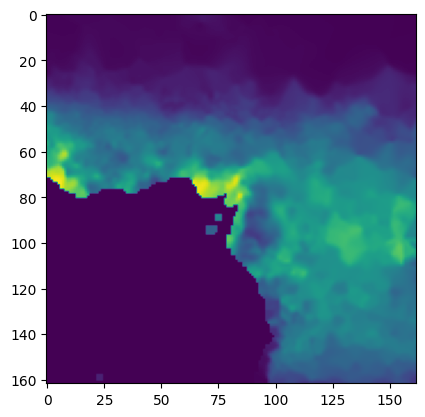

bbox POLYGON ((18.8124 13.7315, 18.8124 -6.2685, -1.1876 -6.2685, -1.1876 13.7315, 18.8124 13.7315))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 540, 'height': 320, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.24953703703703703, 0.0, -19.875,
       0.0, -0.24921875, 39.875)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_11396\994713725.py:13: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data, view=10) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


200.tiff
-1.0 253.30249


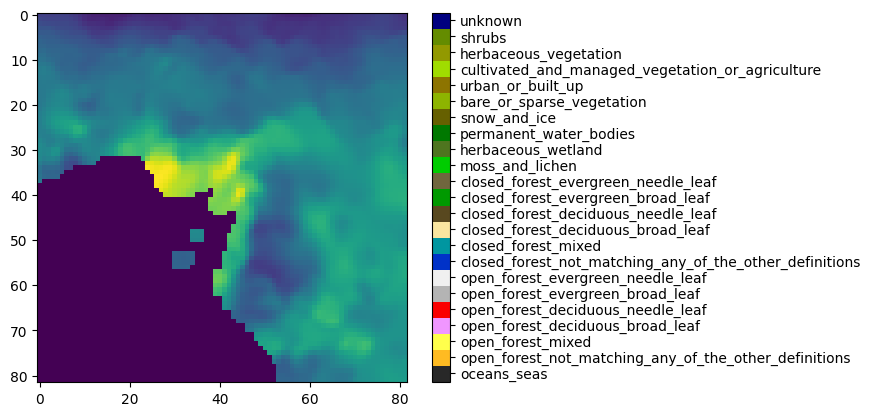

bbox POLYGON ((13.8124 8.7315, 13.8124 -1.2685, 3.8124 -1.2685, 3.8124 8.7315, 13.8124 8.7315))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 540, 'height': 320, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.24953703703703703, 0.0, -19.875,
       0.0, -0.24921875, 39.875)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_11396\994713725.py:15: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data, view=5) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


200.tiff
-1.0 253.30249


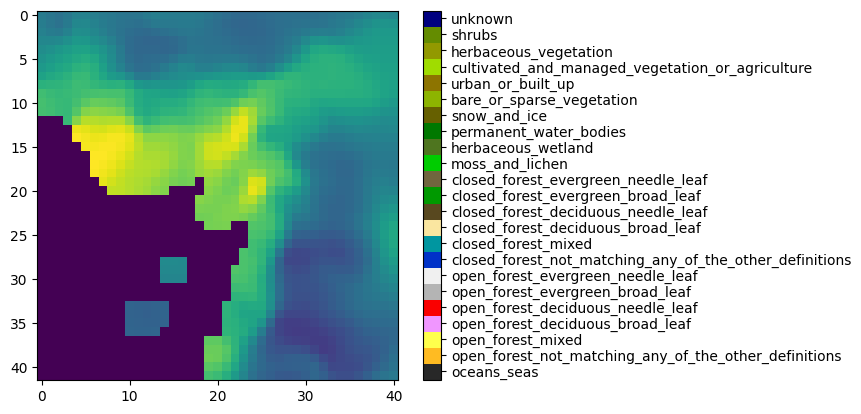

bbox POLYGON ((10.8124 5.7315, 10.8124 1.7315, 6.8124 1.7315, 6.8124 5.7315, 10.8124 5.7315))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 540, 'height': 320, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.24953703703703703, 0.0, -19.875,
       0.0, -0.24921875, 39.875)}
200.tiff


C:\Users\r-kli\AppData\Local\Temp\ipykernel_11396\994713725.py:17: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data, view=2) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


-1.0 246.85167


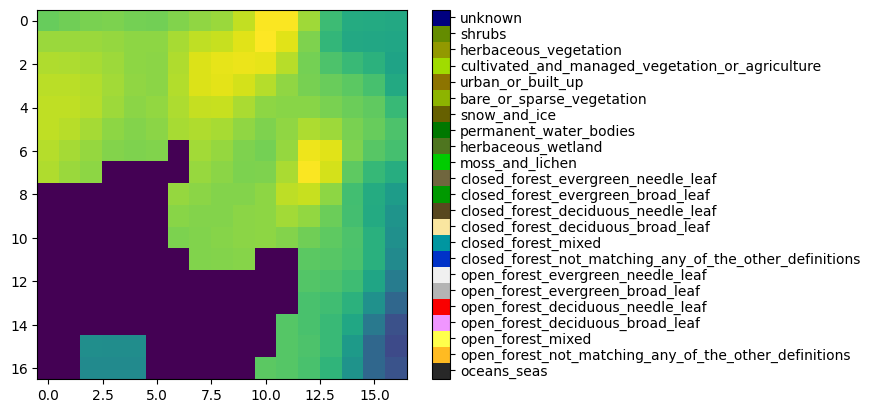

bbox POLYGON ((9.8124 4.7315, 9.8124 2.7315, 7.8124 2.7315, 7.8124 4.7315, 9.8124 4.7315))
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0, 'width': 540, 'height': 320, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.24953703703703703, 0.0, -19.875,
       0.0, -0.24921875, 39.875)}


C:\Users\r-kli\AppData\Local\Temp\ipykernel_11396\994713725.py:19: FionaDeprecationWarning: This function will be removed in version 2.0. Please use CRS.from_epsg() instead.
  generate_land_cover_image(satellite_image_name=file, input_file = data, view=1) #6_28.7472, -16.504.png
C:\Users\r-kli\PycharmProjects\geospatialMalariaPrediction\venv\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


200.tiff
-1.0 245.06169


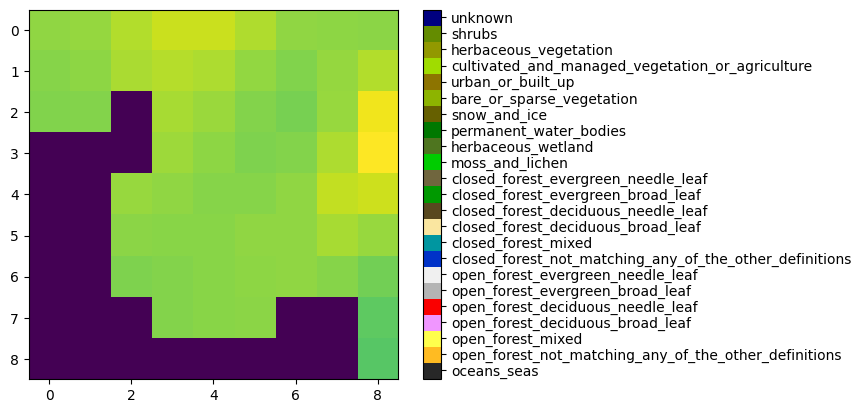

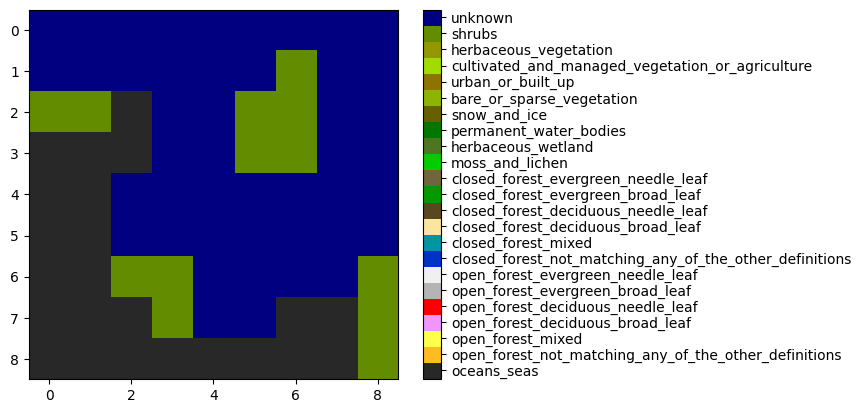

In [6]:
# file = "1_27.3348, -16.9727.png" 
# file = "2_27.3684, -17.479.png" 
# file = "100_27.2562, -16.7782.png"
file = "200_8.8124, 3.7315.png"  #Very good test by manual inspection, clearly on Malabo
# file = "210_31.379, 1.8387.png" # An ok test by manual inspection, we can see it is a bit northwest of lake victoria.


print(np.amin(data), np.amax(data))


generate_land_cover_image(satellite_image_name=file, input_file = data, view=20) #6_28.7472, -16.504.png
show_land_cover(file)
generate_land_cover_image(satellite_image_name=file, input_file = data, view=10) #6_28.7472, -16.504.png
show_land_cover(file)
generate_land_cover_image(satellite_image_name=file, input_file = data, view=5) #6_28.7472, -16.504.png
show_land_cover(file)
generate_land_cover_image(satellite_image_name=file, input_file = data, view=2) #6_28.7472, -16.504.png
show_land_cover(file)
generate_land_cover_image(satellite_image_name=file, input_file = data, view=1) #6_28.7472, -16.504.png
show_land_cover(file)
# generate_land_cover_image(satellite_image_name=file, input_file = data) #6_28.7472, -16.504.png
# show_land_cover(file)

In [ ]:
import os

print(data)

dataset_list = os.listdir('dataset')
for image in dataset_list:
    if image == '.DS_Store':
        continue
    generate_land_cover_image(satellite_image_name=image, input_file = data)

In [ ]:
#Test
from PIL import Image
for i in range(263):

    im = Image.open('landcover/' + str(i+1) + '.tiff')
    imarray = np.array(im)
#     if imarray.shape[0] > 10:
#         print(i+1)
#         continue
    print(i+1, imarray)